<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# The beta binomial model using pymc3

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-objectives" data-toc-modified-id="Learning-objectives-1">Learning objectives</a></span></li><li><span><a href="#Determining-posterior-distributions-with-Markov-Chain-Monte-Carlo" data-toc-modified-id="Determining-posterior-distributions-with-Markov-Chain-Monte-Carlo-2">Determining posterior distributions with Markov Chain Monte Carlo</a></span></li><li><span><a href="#Enter-pymc3" data-toc-modified-id="Enter-pymc3-3">Enter <code>pymc3</code></a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4">Load the data</a></span></li><li><span><a href="#First-pymc3-model" data-toc-modified-id="First-pymc3-model-5">First pymc3 model</a></span></li><li><span><a href="#Model-with-two-players" data-toc-modified-id="Model-with-two-players-6">Model with two players</a></span></li><li><span><a href="#Model-with-many-players" data-toc-modified-id="Model-with-many-players-7">Model with many players</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8">Conclusions</a></span></li></ul></div>

## Learning objectives

- Run the beta-binomial model with pymc3
- Compare to analytic results obtained with conjugate priors
- Get a first feeling about how to set up and run a Bayesian model

## Determining posterior distributions with Markov Chain Monte Carlo

The idea of conjugate priors is very nice and allows for quick computation. In most cases however, you won't find yourself in such a simple situation and heavier machinery is required. 
One possibility is Markov Chain Monte Carlo sampling. The aim is still to obtain the posterior distribution, but rather than trying to obtain a nice formula describing its probability density we are going to obtain a bunch of values representing the posterior distribution. The density function could be obtained as a fit to the histogram of those values.

To illustrate this idea, we are going to start with the baseball dataset where we will be able to verify that our procedure does the right thing.

In [3]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from scipy import stats

## Enter `pymc3`


`Pymc3` is the Bayesian modeling package we will be using. It is a powerful and flexible architecture for performing a huge variety of Bayesian analyses. We will only be scratching the surface today.

In [4]:
import pymc3 as pm

## Load the data

In [5]:
hits = pd.read_csv(
    '../../../../resource-datasets/baseball_hits/career_hits.csv')
hits['misses'] = hits['at_bat'] - hits['hits']

In [6]:
hits.head()

,name,hits,at_bat,average,misses
0,Hank Aaron,3771,12364,0.304998,8593
1,Tommie Aaron,216,944,0.228814,728
2,Andy Abad,2,21,0.095238,19
3,John Abadie,11,49,0.224490,38
4,Ed Abbaticchio,772,3044,0.253614,2272


In [7]:
hits.shape

(9429, 5)

In [8]:
prior_hits = 26+1
prior_misses = 74+1
hits['MAP'] = list(map(lambda k, n: 
                ((prior_hits + 1 + k - 1) / 
                (prior_hits + 1 + k + prior_misses + 1 + (n - k) - 2)),
                 hits.hits.values, 
                 hits.at_bat.values))

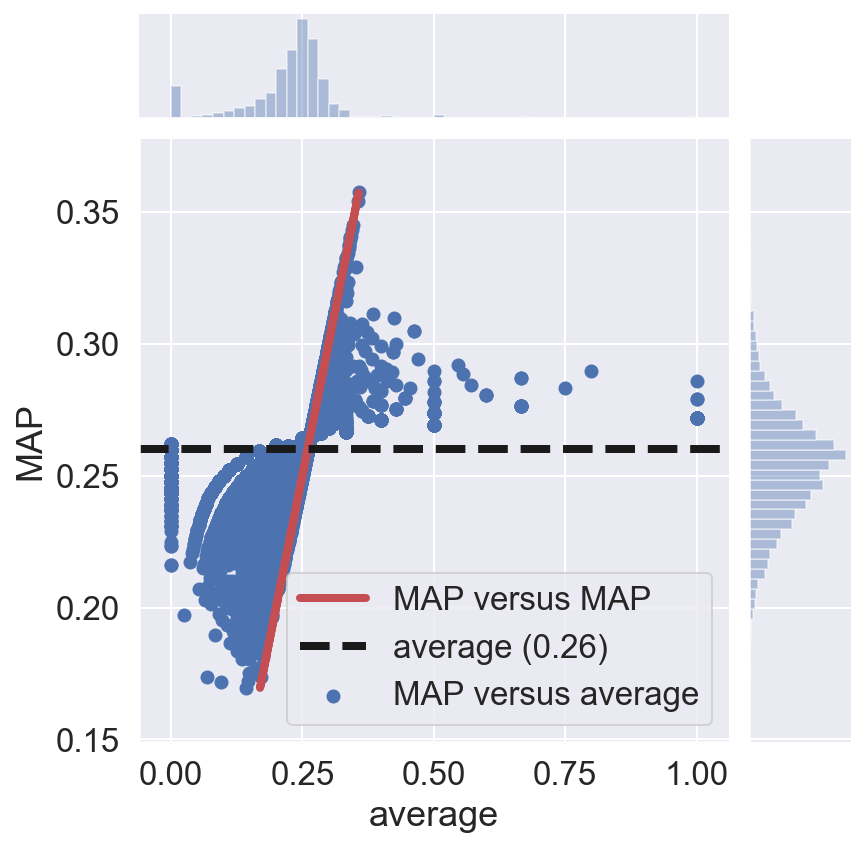

In [9]:
g = sns.jointplot('average', 'MAP', data=hits)
g.ax_joint.plot('MAP', 'MAP', data=hits, lw=4, c='r')
g.ax_joint.axhline(0.26, 0, 1, c='k', ls='--', lw=4)
g.ax_joint.legend(['MAP versus MAP', 'average (0.26)', 'MAP versus average', ])
plt.show()

## First pymc3 model

> **Note**: `pymc3` sets up models using the Python `with ... :` syntax.

In our model, we are going to define a number of probability distributions. For the beta-binomial model, the prior is the Beta-distribution and the likelihood function is the binomial distribution. The prior picks up our prior believes about hitting rates, whereas the likelihood contains information about the observed values.

- Each distribution has a name (the string) and the usual distribution parameters.
- The likelihood function is distinguished by the use of the keyword `observed` where the data values are passed in (numpy arrays are preferred over dataframes).
- We can use `pm.find_MAP()` to find the maximum of the posterior distribution.

In [10]:
i = 100
with pm.Model() as model_i:
    p = pm.Beta('p', alpha=prior_hits, beta=prior_misses)
    likelihood = pm.Binomial('hits', p=p, n=hits.at_bat.values[i], observed=hits.hits.values[i])

We can nicely represent the structure of our model in a graphical way.

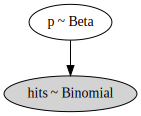

In [11]:
pm.model_to_graphviz(model_i)

Let's compare the estimated MAP with the one calculated using conjugate priors.

In [12]:
with model_i:
    map_estimate = pm.find_MAP()

/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -0.012362, ||grad|| = 0.058824: 100%|██████████| 5/5 [00:00<00:00, 819.14it/s]


In [13]:
print(map_estimate['p'])
print(hits.MAP.iloc[i])
print(map_estimate['p']-hits.MAP.iloc[i])

0.2650602523181773
0.26785714285714285
-0.002796890538965535


In [14]:
# the player we looked at
hits.iloc[i, :]

name       Ham Allen
hits              18
at_bat            66
average     0.272727
misses            48
MAP         0.267857
Name: 100, dtype: object

We can obtain the full posterior distribution by sampling from our model setup. 
This is what the sampling does:

- Sample a value from the prior
- Insert this value into the likelihood
- The product of these two values will produce a single number
- This value obtained for different values from the prior will allow to compare pairwise which ones have higher or lower posterior probability density
- The sampling procedure is designed in such a way that it looks mostly at "interesting" values (those where the posterior probability density is not extremely small)
- In the end we get a trace representing the posterior probability 

In [15]:
with model_i:
    trace_i = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:02<00:00, 8188.21draws/s] 


The trace contains the posterior distributions of all the variables for which you set up priors plus additional variables which are created from the given ones for computational reasons. The sampling actually runs multiple chains from different starting values. The next sampled value in the chain depends to some extent on the previously sampled one. Having multiple chains serves for being less dependent on from where the sampling started.

In [16]:
trace_i.varnames

['p_logodds__', 'p']

We get a nice summary of the relevant variables from the trace. It contains:

- Mean and standard deviation of the posterior distribution
- The `mc_error`, an estimate of the reliability of the posterior distribution (should be small compared to the standard deviation)
- The highest posterior density interval (region of most likely values of the variable, not necessarily symmetric about the mean but indicating where the heights of a very narrowly binned histogram would be highest)
- `Rhat` and `n_eff`: two parameters measuring the quality of the sampling (`Rhat` should be close to one and `n_eff` as high as possible). Pymc3 will complain if it is not content with them.

In [17]:
pm.summary(trace_i)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.267724,0.034145,0.000352,0.201772,0.334251,8230.666769,1.000226


The traceplot shows the distribution of values through a kde-plot and the individual values sampled at the different iteration steps. For the right hand plot it is good if the values are all over the place and the chains are rather indistinguishable. Otherwise you would have to increase the number of tuning steps.

In [18]:
pm.traceplot(trace_i)
plt.show()

ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

The posterior density can be depicted in a nicer way (combining the values from all chains).

In [ ]:
pm.plot_posterior(trace_i, credible_interval=0.95, point_estimate='mode', round_to=3)
plt.show()

We can check that this posterior distribution agrees with the one obtained through conjugate priors.

In [ ]:
beta_i = stats.beta(prior_hits+hits.hits.iloc[i], 
                    prior_misses+hits.misses.iloc[i]+1)
x_vals = np.linspace(0, 1, 100)
plot_post = pm.plot_posterior(trace_i, credible_interval=0.95, 
                              point_estimate='mode', round_to=3)
plot_post[0].plot(x_vals, beta_i.pdf(x_vals), c='r', ls='--')
plt.show()

We can use the posterior distribution to make predictions how likely different observed values (the hits) are for this player given the number of trials.

In [ ]:
ppc = pm.sample_posterior_predictive(trace_i, samples=5000, model=model_i)

In [ ]:
plt.hist(ppc['hits'], bins=np.linspace(0, 35, 36), density=True)
plt.show()

## Model with two players

We don't have to limit to one player. We can determine the posterior hitting probability for two players at the same time. These are just two independent values. As an additional ingredient during the sampling we can keep track of the difference of the already sampled probability values for each player. The individual values are random, but once we have them we calculate the difference in a deterministic way. These value can be stored in a deterministic distribution using `pm.Deterministic`.

In [ ]:
i = 100
j = 200
with pm.Model() as model_ij:
    p_1 = pm.Beta('p_1', alpha=prior_hits, beta=prior_misses)
    p_2 = pm.Beta('p_2', alpha=prior_hits, beta=prior_misses)
    p1_vs_p2 = pm.Deterministic('p1_vs_p2', p_1-p_2)
    likelihood_1 = pm.Binomial('hits_1', p=p_1, n=hits.at_bat.values[i], observed=hits.hits.values[i])
    likelihood_2 = pm.Binomial('hits_2', p=p_2, n=hits.at_bat.values[j], observed=hits.hits.values[j])
    

In [ ]:
with model_ij:
    trace_ij = pm.sample(5000, tune=1000)

Now we have more variables.

In [ ]:
trace_ij.varnames

In [ ]:
pm.summary(trace_ij)

In [ ]:
pm.traceplot(trace_ij)
plt.show()

In [ ]:
pm.plot_posterior(trace_ij, 
                  var_names=['p_1', 'p_2'], 
                  point_estimate='mode', round_to=3)
plt.show()

This is the interesting new part. We can now say how likely it is that player 1 has a higher hitting rate than player 2.

In [ ]:
pm.plot_posterior(trace_ij, var_names=['p1_vs_p2'], ref_val=0)
plt.show()

Using the two posteriors, we can also predict how likely it is that each player produces a certain number of hits (in the observed number of trials different for each). The vertical lines mark the observed number of hits.

In [ ]:
ppc = pm.sample_posterior_predictive(trace_ij, samples=5000, model=model_ij)

In [ ]:
plt.hist(ppc['hits_1'], density=True, bins=np.linspace(0, 35, 36))
plt.hist(ppc['hits_2'], density=True, bins=np.linspace(0, 35, 36))
plt.vlines(hits.hits.values[i], 0, 1)
plt.vlines(hits.hits.values[j], 0, 1)
plt.show()

In [ ]:
hits.iloc[[i, j]]

## Model with many players

We can model all players at the same time. Since this becomes computationally quite costly with so many players we limit ourselves to determining the MAP for each player rather than the full posterior probability density.

To create a prior for each player, we can simply indicate an array shape. Each entry will be combined with the respective observed values in the likelihood.

In [ ]:
with pm.Model() as model:
    p = pm.Beta('p', alpha=prior_hits, beta=prior_misses, 
                shape=len(hits))
    pm.Binomial('hits', p=p, n=hits.at_bat.values, 
                observed=hits.hits.values)

In [ ]:
with model:
    #trace = pm.sample(draws=2000, tune=500)
    trace_map = pm.find_MAP()

The trace for `p` contains as many entries as observations.

In [ ]:
trace_map['p'].shape

We can measure the discrepancy between the MAP estimates obtained with MCMC and conjugate priors.

In [ ]:
(trace_map['p'] - hits.MAP).describe()

In [ ]:
(trace_map['p'] - hits.MAP).hist(bins=20);

We MAP versus maximum likelihood looks still quite the same.

In [ ]:
hits['MAP_MCMC'] = trace_map['p']

In [ ]:
g = sns.jointplot('average', 'MAP_MCMC', data=hits, height=8)
g.ax_joint.plot('MAP_MCMC', 'MAP_MCMC', data=hits, lw=4, c='r')
g.ax_joint.axhline(0.26, 0, 1, c='k', ls='--', lw=4)
g.ax_joint.legend(['MAP_MCMC versus MAP_MCMC', 'average (0.26)', 'MAP_MCMC versus average', ], loc='lower right')
plt.show()

The results match quite exactly.

In [ ]:
sns.scatterplot(x='MAP', y='MAP_MCMC', data=hits)
plt.plot([0.1, 0.4], [0.1, 0.4], lw=4, c='r', ls='--', alpha=0.5)
plt.title('MCMC versus conjugate prior MAP estimates')
plt.show()

## Conclusions

We introduced a new way of obtaining posterior distributions. Here, we produced results that we could equally well have obtained using conjugate priors which would be computationally much more efficient. Full MCMC should really be used if such an alternative is not available. This example serves however for being able to verify the correctness of our results.